Sources:

https://pytorch.org/vision/0.12/_modules/torchvision/models/detection/faster_rcnn.html

https://github.com/EdwardRaff/Inside-Deep-Learning

Raff, E. (2022). Inside Deep Learning: Math, Algorithms, Models (Annotated ed.). Manning.

https://discuss.pytorch.org/t/collate-issue-with-fast-rcnn-tries-to-transform-dictionary-in-generalizedrcnn/62249

https://pytorch.org/vision/0.12/_modules/torchvision/models/detection/faster_rcnn.html

https://stackoverflow.com/questions/49466033/resizing-image-and-its-bounding-box

In [ ]:
# import the necessary packages
import torch
import cv2
import os
import glob
import xml.etree.ElementTree as ET
import torchvision

from torch.utils.data import Dataset
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN

from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid
from torch.nn import Flatten
import torch.nn as nn

os.getcwd()
# os.chdir('..')
!unzip "Images.zip" -d "./Images"

Archive:  Images.zip
replace ./Images/Images/a.cdb477ec-cccd-11ec-bafb-287fcffe570f.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = ""
IMAGES_PATH = os.path.sep.join([BASE_PATH, "Images/Images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])
# define the path to the base output directory
# os.mkdir('annotations')
# os.mkdir("output")
# os.chdir('output')
# os.mkdir("plots")
# os.chdir('..')
BASE_OUTPUT = "output"
# define the path to the output model, label encoder, plots output
# directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector_FasterRCNN_200epochs2.pth"])
LE_PATH = os.path.sep.join([BASE_OUTPUT, "le.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [ ]:
# determine the current device and based on that set the pin memory
# flag
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False
# specify ImageNet mean and standard deviation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 200
BATCH_SIZE = 16
# specify the loss weights
LABELS = 1.0
BBOX = 1.0

In [ ]:
DEVICE

'cuda'

In [ ]:


class ObjectDetector(Module):
    def __init__(self, baseModel, numClasses):
        super(ObjectDetector, self).__init__()
        # initialize the base model and the number of classes
        self.baseModel = baseModel
        self.numClasses = numClasses
        # build the regressor head for outputting the bounding box
        # coordinates
        self.regressor = Sequential(
            Flatten(),
            Linear(2048, 128),
            ReLU(),
            Linear(128, 64),
            ReLU(),
            Linear(64, 32),
            ReLU(),
            Linear(32, 4),
            Sigmoid()
            )
        # build the classifier head to predict the class labels
        self.classifier = Sequential(
            Linear(2048, 512),
            ReLU(),
            Dropout(),
            Linear(512, 512),
            ReLU(),
            Dropout(),
            Linear(512, self.numClasses)
            )
        # set the classifier of our base model to produce outputs
        # from the last convolution block
        self.baseModel.fc = Identity()
    def forward(self, x):
    # pass the inputs through the base model and then obtain
    # predictions from two different branches of the network
        features = self.baseModel(x)
        bboxes = self.regressor(features)
        classLogits = self.classifier(features)
    # return the outputs as a tuple
        return (bboxes, classLogits)

In [ ]:
!pip install imutils

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import time
import cv2
import os
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
os.getcwd()

'/content'

In [ ]:
path = './Images/Images'
xml_files = glob.glob(path+"/*.xml")
xml_files = sorted(xml_files)
img_files = glob.glob(path+"/*.jpg")
img_files = sorted(img_files)
len(img_files)

data = []
labels = []
bboxes = []
imagePaths = []

for i, file in enumerate(xml_files):
    print(file)
    print(img_files[i])
    root = ET.parse(file).getroot()
    xmin = int(root.find("object").find("bndbox").find("xmin").text)
    ymin = int(root.find("object").find("bndbox").find("ymin").text)
    xmax = int(root.find("object").find("bndbox").find("xmax").text)
    ymax = int(root.find("object").find("bndbox").find("ymax").text)
    class_name = root.find("object").find("name").text.lower()

    imagePath = img_files[i]
    image = cv2.imread(imagePath)
    (h,w)=image.shape[:2]

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    x_scale = ( 224 / w)
    y_scale = ( 224 / h)
    
    startx = int(xmin*x_scale)
    starty = int(ymin*y_scale)
    endx = int(xmax*x_scale)
    endy = int(ymax*y_scale)
    
    data.append(image)
    labels.append(class_name)
    bboxes.append((startx, starty, endx, endy))
    imagePaths.append(imagePath)
    
# labels    

./Images/Images/ThankYou.4bd68bea-ccd8-11ec-b32d-287fcffe570f.xml
./Images/Images/ThankYou.4bd68bea-ccd8-11ec-b32d-287fcffe570f.jpg
./Images/Images/ThankYou.4da5dcd5-ccd8-11ec-bcf7-287fcffe570f.xml
./Images/Images/ThankYou.4da5dcd5-ccd8-11ec-bcf7-287fcffe570f.jpg
./Images/Images/ThankYou.4f748e67-ccd8-11ec-bafb-287fcffe570f.xml
./Images/Images/ThankYou.4f748e67-ccd8-11ec-bafb-287fcffe570f.jpg
./Images/Images/ThankYou.5145400d-ccd8-11ec-a319-287fcffe570f.xml
./Images/Images/ThankYou.5145400d-ccd8-11ec-a319-287fcffe570f.jpg
./Images/Images/ThankYou.5315c7a4-ccd8-11ec-ae63-287fcffe570f.xml
./Images/Images/ThankYou.5315c7a4-ccd8-11ec-ae63-287fcffe570f.jpg
./Images/Images/ThankYou.54e65b5d-ccd8-11ec-b94a-287fcffe570f.xml
./Images/Images/ThankYou.54e65b5d-ccd8-11ec-b94a-287fcffe570f.jpg
./Images/Images/ThankYou.56b93aaa-ccd8-11ec-ae0a-287fcffe570f.xml
./Images/Images/ThankYou.56b93aaa-ccd8-11ec-ae0a-287fcffe570f.jpg
./Images/Images/ThankYou.58859e9b-ccd8-11ec-a668-287fcffe570f.xml
./Images/I

In [ ]:
#from the xml files I will extract the necessary bounding boxes to find my data
class SignLanguageData(torch.utils.data.Dataset):
    # initialize the constructor
    def __init__(self, tensors, transforms=None):
        self.tensors = tensors
        self.transforms = transforms
    def __getitem__(self, index):
        # grab the image, label, and its bounding box coordinates
        image = self.tensors[0][index]
        label = self.tensors[1][index]
        bbox = self.tensors[2][index]
        # transpose the image such that its channel dimension becomes
        # the leading one
        image = image.permute(2, 0, 1)
        # check to see if we have any image transformations to apply
        # and if so, apply them
        if self.transforms:
            image = self.transforms(image)
        # return a tuple of the images, labels, and bounding
        # box coordinates
        target = {}
        bbox = bbox.unsqueeze(0)
        target["boxes"] = bbox
        label = label.unsqueeze(0)
        target["labels"] = label
#         return (image, label, bbox)
        return image, target
    def __len__(self):
        # return the size of the dataset
        return self.tensors[0].size(0)

In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform label encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

In [ ]:
split = train_test_split(data, labels, bboxes, imagePaths,
test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [ ]:
(trainImages, testImages) = torch.tensor(trainImages),torch.tensor(testImages)
(trainLabels, testLabels) = torch.tensor(trainLabels),torch.tensor(testLabels)
(trainBBoxes, testBBoxes) = torch.tensor(trainBBoxes),torch.tensor(testBBoxes)

In [ ]:
from torchvision import transforms

# transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.Normalize(mean=MEAN, std=STD)
# ])

transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])
#https://github.com/EdwardRaff/Inside-Deep-Learning/blob/main/Chapter_8.ipynb
def collate_fn(batch):
    """
    batch is going to contain a python list of objects. In our case, our data loader returns (Tensor, Dict) pairs
    The FasterRCNN algorithm wants a List[Tensors] and a List[Dict]. So we will use this function to convert the 
    batch of data into the form we want, and then give it to the Dataloader to use
    """
    imgs = []
    labels = []
    for img, label in batch:
        imgs.append(img)
        labels.append(label)
    return imgs, labels

In [ ]:
trainDS = SignLanguageData((trainImages, trainLabels, trainBBoxes),transforms=transforms)
testDS = SignLanguageData((testImages, testLabels, testBBoxes),transforms=transforms)
print("[INFO] total training samples: {}...".format(len(trainDS)))
print("[INFO] total test samples: {}...".format(len(testDS)))
# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(testDS) // BATCH_SIZE
# create data loaders
trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=PIN_MEMORY)
testLoader = DataLoader(testDS, batch_size=BATCH_SIZE, collate_fn=collate_fn,  pin_memory=PIN_MEMORY)

[INFO] total training samples: 544...
[INFO] total test samples: 137...


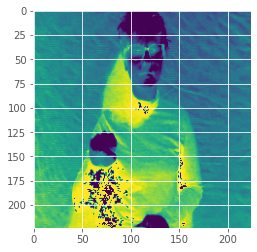

In [ ]:
from matplotlib.pyplot import imshow
x, y = trainDS[0] # Grab an image with its labels
imshow(x.numpy()[0,:])

In [ ]:
print(y) #prints out everything
print("Boxes: ", y['boxes']) #prints a tensor showing the pixel locations of the corners for all 3 objects
print("Labels: ", y['labels'])

{'boxes': tensor([[ 54., 123.,  91., 167.]]), 'labels': tensor([23])}
Boxes:  tensor([[ 54., 123.,  91., 167.]])
Labels:  tensor([23])


In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'hello': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'my': 14, 'n': 15, 'name': 16, 'no': 17, 'o': 18, 'p': 19, 'project': 20, 'q': 21, 'r': 22, 's': 23, 't': 24, 'thank you': 25, 'this': 26, 'u': 27, 'v': 28, 'w': 29, 'x': 30, 'y': 31, 'yes': 32, 'z': 33}


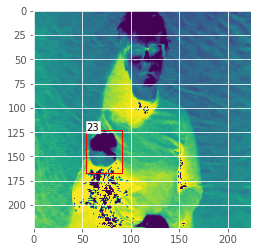

In [ ]:
import matplotlib.patches as patches
def plotDetection(ax, abs_pos, label=None):
    """
    ax: the matpllib axis to add this plot to
    abs_pos: the positions of the bounding box
    label: the label of the prediction to add
    """
    x1, y1, x2, y2 = abs_pos
    #make a rectangle for the bounding box
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    #add the label if given
    if label is not None:
        plt.text(x1+0.5, y1, label, color='black', bbox=dict(facecolor='white', edgecolor='white', pad=1.0))
    
    return 
fig,ax = plt.subplots(1)
ax.imshow(x.numpy()[0,:])
plotDetection(ax, y['boxes'][0], y['labels'][0].item())

In [ ]:
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()
# load the ResNet50 network
# resnet = resnet50(pretrained=True)
rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# freeze all ResNet50 layers so they will *not* be updated during the
# training process
for param in rcnn.parameters():
    param.requires_grad = False

# modelOutputFeats = model.fc.in_features
# model.fc = nn.Linear(modelOutputFeats, len(trainDS.classes))
# model = model.to(DEVICE)
    

[INFO] saving testing image paths...


In [ ]:
#How many channels are in the input?
C = 3
#How many classes are there?
classes = 34
#How many filters in our backbone
n_filters = 32

In [ ]:
#Define our helper function that creates a hidden layer for a CNN
def cnnLayer(in_filters, out_filters, kernel_size=3):
    """
    in_filters: how many channels are in the input to this layer
    out_filters: how many channels should this layer output
    kernel_size: how large should the filters of this layer be
    """
    padding = kernel_size//2
    return nn.Sequential(
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.BatchNorm2d(out_filters),
        nn.LeakyReLU(), # I'm not setting the leak value to anything just to make the code shorter. 
    )

def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [ ]:
backbone = nn.Sequential(
    cnnLayer(C, n_filters),    
    cnnLayer(n_filters, n_filters),
    cnnLayer(n_filters, n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters),
    cnnLayer(4*n_filters, 4*n_filters),
)
#Let Faster RCNN know exactly how many output channels to expect
backbone.out_channels = n_filters*4

In [ ]:
# How many proposals $k$ should be generated? Every aspect ration will be one, and the process will be repeated for multiple image sizes 
anchor_generator = AnchorGenerator(sizes=((224),), aspect_ratios=((1.0),)) #To make this run faster, we are telling PyTorch to look for only square images that are 32 x 32 in size

#Tell PyTorch to use the final output of the backbone as the featuremap (['0']), use adaptive pooling down to a 7x7 grid (output_size=7)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
#sampling_ratio is poorly named, and controls details on how the RoI grabs slices of the feature map when a fractional pixel location is predicted (e.g., 5.8 instead of 6). We are not going to go into those low level details, 2 is a reasonable default for most work. 
        
#Now we can create the FasterRCNN object. We give it the backbone network, number of classes, min & max size to process images at (we know all our images at 100 pixels), a mean and standard deviation to subtract from the images, and the anchor generation (RPN) and RoI objects
model = FasterRCNN(backbone, num_classes=classes, image_mean = (0.5,), image_std = (0.5,), min_size=100, max_size=100, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)


In [ ]:
model = model.train()
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters())

for epoch in tqdm(range(1), desc="Epoch", disable=False):
    running_loss = 0.0
    for inputs, labels in tqdm(trainLoader, desc="Train Batch", leave=False, disable=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, DEVICE)
        labels = moveTo(labels, DEVICE)

        optimizer.zero_grad()
        #rcnn wants model(inputs, labels) - not just model(inputs)
        losses = model(inputs, labels)
        # Compute loss, RCNN gives us a list of losses to add up.
        loss = 0
        for partial_loss in losses.values():
            loss += partial_loss
        #now proceed like normal
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

Epoch: 100%|██████████| 1/1 [00:04<00:00,  4.45s/it]


In [ ]:
# objectDetector = ObjectDetector(rcnn, len(le.classes_))
# objectDetector = objectDetector.to(DEVICE)
# # define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()
# # initialize the optimizer, compile the model, and show the model
# # summary
opt = Adam(model.parameters(), lr=INIT_LR)
# print(objectDetector)
# # initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],"val_class_acc": []}

In [ ]:
#https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch
from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers
def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    model.eval()

    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    # TODO: Move this to a function
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    model.rpn.training=True
    #model.roi_heads.training=True


    #####proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    #####detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
    model.rpn.training=False
    model.roi_heads.training=False
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses, detections

In [ ]:
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    # loop over the training set
    for inputs, labels in trainLoader:
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, DEVICE)
        labels = moveTo(labels, DEVICE)
        # perform a forward pass and calculate the training loss
        predictions = model(inputs, labels)
        # print(predictions.keys())
#         print(predictions)
        proposal_losses = {}
        proposal_losses = {
        "loss_objectness": predictions['loss_objectness'],
        "loss_rpn_box_reg":  predictions['loss_rpn_box_reg'],
        }
        detector_losses = {}
        detector_losses = {
            "loss_classifier": predictions['loss_classifier'], 
            "loss_box_reg": predictions['loss_box_reg']
        }
        
        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)
        
#         bboxLoss = predictions['loss_box_reg'] + predictions['loss_classifier']
#         classLoss = predictions['loss_objectness'] + predictions['loss_rpn_box_reg']
#         totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)
        totalLoss = sum(loss for loss in losses.values())
        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        totalLoss.backward()
        opt.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += totalLoss
#         trainCorrect += (predictions[1].argmax(1) == labels).type(
#             torch.float).sum().item()
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for inputs, labels in testLoader:
            # send the input to the device
            inputs = moveTo(inputs, DEVICE)
            labels = moveTo(labels, DEVICE)
            # make the predictions and calculate the validation loss
            predictions = model(inputs, labels)
            # print(predictions)
            losses, detections = eval_forward(model, inputs, labels)
            totalLoss = sum(loss for loss in losses.values())
            totalValLoss += totalLoss
            # calculate the number of correct predictions
            # print(labels[0]['labels'])
            for i, prediction in enumerate(predictions):
                try:
                    valCorrect += (prediction['labels'][prediction['scores'].argmax(0)] == labels[i]['labels']).type(
                        torch.float).sum().item()
                except:
                    valCorrect += 0
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    # calculate the training and validation accuracy
#     trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(testDS)
    # update our training history
    H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
#     H["train_class_acc"].append(trainCorrect)
    H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_class_acc"].append(valCorrect)
    if valCorrect == max(H["val_class_acc"]):
        torch.save(model.state_dict(), MODEL_PATH)
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}".format(
        avgTrainLoss ))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
        avgValLoss, valCorrect))
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))


[INFO] training the network...


  0%|          | 1/200 [00:05<19:53,  6.00s/it]

[INFO] EPOCH: 1/200
Train loss: 0.707619
Val loss: 0.723656, Val accuracy: 0.0000


  1%|          | 2/200 [00:11<18:57,  5.75s/it]

[INFO] EPOCH: 2/200
Train loss: 0.675587
Val loss: 0.719941, Val accuracy: 0.0000


  2%|▏         | 3/200 [00:16<18:08,  5.53s/it]

[INFO] EPOCH: 3/200
Train loss: 0.659672
Val loss: 0.712957, Val accuracy: 0.0000


  2%|▏         | 4/200 [00:21<17:30,  5.36s/it]

[INFO] EPOCH: 4/200
Train loss: 0.660241
Val loss: 0.720105, Val accuracy: 0.0292


  2%|▎         | 5/200 [00:27<17:25,  5.36s/it]

[INFO] EPOCH: 5/200
Train loss: 0.658116
Val loss: 0.730783, Val accuracy: 0.0511


  3%|▎         | 6/200 [00:31<16:26,  5.09s/it]

[INFO] EPOCH: 6/200
Train loss: 0.671966
Val loss: 0.747884, Val accuracy: 0.0730


  4%|▎         | 7/200 [00:36<15:54,  4.95s/it]

[INFO] EPOCH: 7/200
Train loss: 0.661383
Val loss: 0.739528, Val accuracy: 0.0438


  4%|▍         | 8/200 [00:40<15:17,  4.78s/it]

[INFO] EPOCH: 8/200
Train loss: 0.656744
Val loss: 0.723940, Val accuracy: 0.0803


  4%|▍         | 9/200 [00:45<14:46,  4.64s/it]

[INFO] EPOCH: 9/200
Train loss: 0.656631
Val loss: 0.712663, Val accuracy: 0.0949


  5%|▌         | 10/200 [00:49<14:26,  4.56s/it]

[INFO] EPOCH: 10/200
Train loss: 0.648425
Val loss: 0.707061, Val accuracy: 0.1168


  6%|▌         | 11/200 [00:53<14:09,  4.49s/it]

[INFO] EPOCH: 11/200
Train loss: 0.629507
Val loss: 0.694365, Val accuracy: 0.1752


  6%|▌         | 12/200 [00:58<14:07,  4.51s/it]

[INFO] EPOCH: 12/200
Train loss: 0.632164
Val loss: 0.715477, Val accuracy: 0.1752


  6%|▋         | 13/200 [01:02<13:55,  4.47s/it]

[INFO] EPOCH: 13/200
Train loss: 0.633209
Val loss: 0.701460, Val accuracy: 0.2117


  7%|▋         | 14/200 [01:07<13:39,  4.41s/it]

[INFO] EPOCH: 14/200
Train loss: 0.617336
Val loss: 0.676707, Val accuracy: 0.2044


  8%|▊         | 15/200 [01:11<13:30,  4.38s/it]

[INFO] EPOCH: 15/200
Train loss: 0.613059
Val loss: 0.713700, Val accuracy: 0.2409


  8%|▊         | 16/200 [01:15<13:19,  4.34s/it]

[INFO] EPOCH: 16/200
Train loss: 0.602663
Val loss: 0.675001, Val accuracy: 0.2190


  8%|▊         | 17/200 [01:19<13:08,  4.31s/it]

[INFO] EPOCH: 17/200
Train loss: 0.615583
Val loss: 0.693585, Val accuracy: 0.2336


  9%|▉         | 18/200 [01:24<13:03,  4.31s/it]

[INFO] EPOCH: 18/200
Train loss: 0.595534
Val loss: 0.680694, Val accuracy: 0.2628


 10%|▉         | 19/200 [01:28<12:57,  4.30s/it]

[INFO] EPOCH: 19/200
Train loss: 0.591797
Val loss: 0.669389, Val accuracy: 0.3139


 10%|█         | 20/200 [01:32<12:48,  4.27s/it]

[INFO] EPOCH: 20/200
Train loss: 0.581879
Val loss: 0.660105, Val accuracy: 0.3066


 10%|█         | 21/200 [01:37<12:45,  4.27s/it]

[INFO] EPOCH: 21/200
Train loss: 0.577860
Val loss: 0.669011, Val accuracy: 0.2701


 11%|█         | 22/200 [01:41<12:43,  4.29s/it]

[INFO] EPOCH: 22/200
Train loss: 0.579019
Val loss: 0.673686, Val accuracy: 0.4088


 12%|█▏        | 23/200 [01:45<12:36,  4.27s/it]

[INFO] EPOCH: 23/200
Train loss: 0.568939
Val loss: 0.653588, Val accuracy: 0.3577


 12%|█▏        | 24/200 [01:49<12:30,  4.26s/it]

[INFO] EPOCH: 24/200
Train loss: 0.563882
Val loss: 0.626598, Val accuracy: 0.3869


 12%|█▎        | 25/200 [01:54<12:33,  4.31s/it]

[INFO] EPOCH: 25/200
Train loss: 0.558836
Val loss: 0.648459, Val accuracy: 0.4307


 13%|█▎        | 26/200 [01:58<12:22,  4.27s/it]

[INFO] EPOCH: 26/200
Train loss: 0.557142
Val loss: 0.638444, Val accuracy: 0.4161


 14%|█▎        | 27/200 [02:02<12:15,  4.25s/it]

[INFO] EPOCH: 27/200
Train loss: 0.560010
Val loss: 0.661553, Val accuracy: 0.3796


 14%|█▍        | 28/200 [02:06<12:06,  4.23s/it]

[INFO] EPOCH: 28/200
Train loss: 0.553861
Val loss: 0.631705, Val accuracy: 0.4234


 14%|█▍        | 29/200 [02:11<12:06,  4.25s/it]

[INFO] EPOCH: 29/200
Train loss: 0.555574
Val loss: 0.646431, Val accuracy: 0.4745


 15%|█▌        | 30/200 [02:15<12:03,  4.26s/it]

[INFO] EPOCH: 30/200
Train loss: 0.542247
Val loss: 0.628975, Val accuracy: 0.4818


 16%|█▌        | 31/200 [02:19<11:59,  4.26s/it]

[INFO] EPOCH: 31/200
Train loss: 0.541825
Val loss: 0.636305, Val accuracy: 0.5182


 16%|█▌        | 32/200 [02:23<11:50,  4.23s/it]

[INFO] EPOCH: 32/200
Train loss: 0.541739
Val loss: 0.644757, Val accuracy: 0.4891


 16%|█▋        | 33/200 [02:28<11:45,  4.22s/it]

[INFO] EPOCH: 33/200
Train loss: 0.544525
Val loss: 0.633812, Val accuracy: 0.5182


 17%|█▋        | 34/200 [02:32<11:42,  4.23s/it]

[INFO] EPOCH: 34/200
Train loss: 0.531233
Val loss: 0.608910, Val accuracy: 0.5182


 18%|█▊        | 35/200 [02:36<11:36,  4.22s/it]

[INFO] EPOCH: 35/200
Train loss: 0.533024
Val loss: 0.660232, Val accuracy: 0.5474


 18%|█▊        | 36/200 [02:40<11:34,  4.24s/it]

[INFO] EPOCH: 36/200
Train loss: 0.548587
Val loss: 0.614013, Val accuracy: 0.5547


 18%|█▊        | 37/200 [02:44<11:29,  4.23s/it]

[INFO] EPOCH: 37/200
Train loss: 0.533062
Val loss: 0.639988, Val accuracy: 0.5474


 19%|█▉        | 38/200 [02:49<11:23,  4.22s/it]

[INFO] EPOCH: 38/200
Train loss: 0.516143
Val loss: 0.635866, Val accuracy: 0.4964


 20%|█▉        | 39/200 [02:53<11:20,  4.23s/it]

[INFO] EPOCH: 39/200
Train loss: 0.517005
Val loss: 0.635969, Val accuracy: 0.5839


 20%|██        | 40/200 [02:57<11:11,  4.19s/it]

[INFO] EPOCH: 40/200
Train loss: 0.524855
Val loss: 0.644628, Val accuracy: 0.5401


 20%|██        | 41/200 [03:01<11:03,  4.17s/it]

[INFO] EPOCH: 41/200
Train loss: 0.531683
Val loss: 0.654768, Val accuracy: 0.5766


 21%|██        | 42/200 [03:05<11:02,  4.19s/it]

[INFO] EPOCH: 42/200
Train loss: 0.506815
Val loss: 0.642309, Val accuracy: 0.6058


 22%|██▏       | 43/200 [03:10<10:57,  4.19s/it]

[INFO] EPOCH: 43/200
Train loss: 0.512144
Val loss: 0.621524, Val accuracy: 0.5912


 22%|██▏       | 44/200 [03:14<10:56,  4.21s/it]

[INFO] EPOCH: 44/200
Train loss: 0.505213
Val loss: 0.640894, Val accuracy: 0.6423


 22%|██▎       | 45/200 [03:18<10:50,  4.20s/it]

[INFO] EPOCH: 45/200
Train loss: 0.508298
Val loss: 0.639984, Val accuracy: 0.5328


 23%|██▎       | 46/200 [03:22<10:44,  4.19s/it]

[INFO] EPOCH: 46/200
Train loss: 0.504485
Val loss: 0.636721, Val accuracy: 0.6350


 24%|██▎       | 47/200 [03:26<10:39,  4.18s/it]

[INFO] EPOCH: 47/200
Train loss: 0.500869
Val loss: 0.628036, Val accuracy: 0.5912


 24%|██▍       | 48/200 [03:31<10:37,  4.19s/it]

[INFO] EPOCH: 48/200
Train loss: 0.500456
Val loss: 0.679303, Val accuracy: 0.6569


 24%|██▍       | 49/200 [03:35<10:32,  4.19s/it]

[INFO] EPOCH: 49/200
Train loss: 0.498800
Val loss: 0.640905, Val accuracy: 0.6277


 25%|██▌       | 50/200 [03:39<10:27,  4.18s/it]

[INFO] EPOCH: 50/200
Train loss: 0.497478
Val loss: 0.654165, Val accuracy: 0.6131


 26%|██▌       | 51/200 [03:43<10:22,  4.18s/it]

[INFO] EPOCH: 51/200
Train loss: 0.503507
Val loss: 0.604014, Val accuracy: 0.6131


 26%|██▌       | 52/200 [03:47<10:17,  4.17s/it]

[INFO] EPOCH: 52/200
Train loss: 0.496761
Val loss: 0.592402, Val accuracy: 0.6277


 26%|██▋       | 53/200 [03:51<10:12,  4.17s/it]

[INFO] EPOCH: 53/200
Train loss: 0.484890
Val loss: 0.631641, Val accuracy: 0.6277


 27%|██▋       | 54/200 [03:56<10:09,  4.17s/it]

[INFO] EPOCH: 54/200
Train loss: 0.485111
Val loss: 0.628982, Val accuracy: 0.6496


 28%|██▊       | 55/200 [04:00<10:07,  4.19s/it]

[INFO] EPOCH: 55/200
Train loss: 0.499701
Val loss: 0.644654, Val accuracy: 0.6642


 28%|██▊       | 56/200 [04:04<09:59,  4.17s/it]

[INFO] EPOCH: 56/200
Train loss: 0.495724
Val loss: 0.632061, Val accuracy: 0.6569


 28%|██▊       | 57/200 [04:08<09:55,  4.17s/it]

[INFO] EPOCH: 57/200
Train loss: 0.490456
Val loss: 0.646001, Val accuracy: 0.6788


 29%|██▉       | 58/200 [04:12<09:53,  4.18s/it]

[INFO] EPOCH: 58/200
Train loss: 0.477924
Val loss: 0.668452, Val accuracy: 0.6934


 30%|██▉       | 59/200 [04:16<09:45,  4.16s/it]

[INFO] EPOCH: 59/200
Train loss: 0.478026
Val loss: 0.669421, Val accuracy: 0.6277


 30%|███       | 60/200 [04:21<09:46,  4.19s/it]

[INFO] EPOCH: 60/200
Train loss: 0.474750
Val loss: 0.638073, Val accuracy: 0.7153


 30%|███       | 61/200 [04:25<09:39,  4.17s/it]

[INFO] EPOCH: 61/200
Train loss: 0.474682
Val loss: 0.674961, Val accuracy: 0.6715


 31%|███       | 62/200 [04:29<09:34,  4.16s/it]

[INFO] EPOCH: 62/200
Train loss: 0.471096
Val loss: 0.653740, Val accuracy: 0.7080


 32%|███▏      | 63/200 [04:33<09:27,  4.14s/it]

[INFO] EPOCH: 63/200
Train loss: 0.459820
Val loss: 0.639846, Val accuracy: 0.6861


 32%|███▏      | 64/200 [04:37<09:23,  4.14s/it]

[INFO] EPOCH: 64/200
Train loss: 0.467459
Val loss: 0.576301, Val accuracy: 0.6788


 32%|███▎      | 65/200 [04:41<09:19,  4.14s/it]

[INFO] EPOCH: 65/200
Train loss: 0.468447
Val loss: 0.644186, Val accuracy: 0.6642


 33%|███▎      | 66/200 [04:45<09:15,  4.14s/it]

[INFO] EPOCH: 66/200
Train loss: 0.469678
Val loss: 0.636803, Val accuracy: 0.6934


 34%|███▎      | 67/200 [04:50<09:11,  4.15s/it]

[INFO] EPOCH: 67/200
Train loss: 0.456042
Val loss: 0.636067, Val accuracy: 0.6861


 34%|███▍      | 68/200 [04:54<09:12,  4.19s/it]

[INFO] EPOCH: 68/200
Train loss: 0.451908
Val loss: 0.638487, Val accuracy: 0.7226


 34%|███▍      | 69/200 [04:58<09:08,  4.18s/it]

[INFO] EPOCH: 69/200
Train loss: 0.454225
Val loss: 0.630462, Val accuracy: 0.7007


 35%|███▌      | 70/200 [05:02<09:04,  4.19s/it]

[INFO] EPOCH: 70/200
Train loss: 0.448396
Val loss: 0.613342, Val accuracy: 0.6715


 36%|███▌      | 71/200 [05:06<08:57,  4.17s/it]

[INFO] EPOCH: 71/200
Train loss: 0.450015
Val loss: 0.616475, Val accuracy: 0.7153


 36%|███▌      | 72/200 [05:10<08:52,  4.16s/it]

[INFO] EPOCH: 72/200
Train loss: 0.455322
Val loss: 0.651638, Val accuracy: 0.7007


 36%|███▋      | 73/200 [05:15<08:48,  4.16s/it]

[INFO] EPOCH: 73/200
Train loss: 0.454534
Val loss: 0.645960, Val accuracy: 0.6496


 37%|███▋      | 74/200 [05:19<08:43,  4.15s/it]

[INFO] EPOCH: 74/200
Train loss: 0.444508
Val loss: 0.692049, Val accuracy: 0.6642


 38%|███▊      | 75/200 [05:23<08:40,  4.16s/it]

[INFO] EPOCH: 75/200
Train loss: 0.447152
Val loss: 0.655107, Val accuracy: 0.7226


 38%|███▊      | 76/200 [05:27<08:38,  4.18s/it]

[INFO] EPOCH: 76/200
Train loss: 0.447861
Val loss: 0.673477, Val accuracy: 0.6934


 38%|███▊      | 77/200 [05:31<08:32,  4.17s/it]

[INFO] EPOCH: 77/200
Train loss: 0.450355
Val loss: 0.651882, Val accuracy: 0.6861


 39%|███▉      | 78/200 [05:35<08:27,  4.16s/it]

[INFO] EPOCH: 78/200
Train loss: 0.437494
Val loss: 0.691456, Val accuracy: 0.6861


 40%|███▉      | 79/200 [05:40<08:23,  4.16s/it]

[INFO] EPOCH: 79/200
Train loss: 0.437617
Val loss: 0.622788, Val accuracy: 0.6642


 40%|████      | 80/200 [05:44<08:17,  4.15s/it]

[INFO] EPOCH: 80/200
Train loss: 0.431255
Val loss: 0.656198, Val accuracy: 0.6496


 40%|████      | 81/200 [05:48<08:11,  4.13s/it]

[INFO] EPOCH: 81/200
Train loss: 0.433555
Val loss: 0.671150, Val accuracy: 0.6934


 41%|████      | 82/200 [05:52<08:09,  4.15s/it]

[INFO] EPOCH: 82/200
Train loss: 0.424693
Val loss: 0.656234, Val accuracy: 0.7299


 42%|████▏     | 83/200 [05:56<08:03,  4.13s/it]

[INFO] EPOCH: 83/200
Train loss: 0.421324
Val loss: 0.654335, Val accuracy: 0.6934


 42%|████▏     | 84/200 [06:00<08:03,  4.16s/it]

[INFO] EPOCH: 84/200
Train loss: 0.428878
Val loss: 0.673654, Val accuracy: 0.7299


 42%|████▎     | 85/200 [06:04<07:57,  4.15s/it]

[INFO] EPOCH: 85/200
Train loss: 0.438533
Val loss: 0.659448, Val accuracy: 0.6861


 43%|████▎     | 86/200 [06:09<07:55,  4.17s/it]

[INFO] EPOCH: 86/200
Train loss: 0.435097
Val loss: 0.655271, Val accuracy: 0.7299


 44%|████▎     | 87/200 [06:13<07:49,  4.15s/it]

[INFO] EPOCH: 87/200
Train loss: 0.426892
Val loss: 0.655979, Val accuracy: 0.6788


 44%|████▍     | 88/200 [06:17<07:45,  4.15s/it]

[INFO] EPOCH: 88/200
Train loss: 0.421018
Val loss: 0.665671, Val accuracy: 0.6715


 44%|████▍     | 89/200 [06:21<07:40,  4.15s/it]

[INFO] EPOCH: 89/200
Train loss: 0.423037
Val loss: 0.669412, Val accuracy: 0.7080


 45%|████▌     | 90/200 [06:25<07:34,  4.14s/it]

[INFO] EPOCH: 90/200
Train loss: 0.424247
Val loss: 0.616517, Val accuracy: 0.7007


 46%|████▌     | 91/200 [06:29<07:29,  4.12s/it]

[INFO] EPOCH: 91/200
Train loss: 0.417482
Val loss: 0.628413, Val accuracy: 0.7007


 46%|████▌     | 92/200 [06:33<07:25,  4.13s/it]

[INFO] EPOCH: 92/200
Train loss: 0.422872
Val loss: 0.657987, Val accuracy: 0.7080


 46%|████▋     | 93/200 [06:38<07:21,  4.13s/it]

[INFO] EPOCH: 93/200
Train loss: 0.423499
Val loss: 0.676609, Val accuracy: 0.6934


 47%|████▋     | 94/200 [06:42<07:17,  4.13s/it]

[INFO] EPOCH: 94/200
Train loss: 0.407734
Val loss: 0.644787, Val accuracy: 0.7226


 48%|████▊     | 95/200 [06:46<07:13,  4.13s/it]

[INFO] EPOCH: 95/200
Train loss: 0.415153
Val loss: 0.668856, Val accuracy: 0.7080


 48%|████▊     | 96/200 [06:50<07:08,  4.12s/it]

[INFO] EPOCH: 96/200
Train loss: 0.410158
Val loss: 0.654032, Val accuracy: 0.6788


 48%|████▊     | 97/200 [06:54<07:04,  4.12s/it]

[INFO] EPOCH: 97/200
Train loss: 0.411529
Val loss: 0.660071, Val accuracy: 0.7080


 49%|████▉     | 98/200 [06:58<06:58,  4.11s/it]

[INFO] EPOCH: 98/200
Train loss: 0.410535
Val loss: 0.619584, Val accuracy: 0.7153


 50%|████▉     | 99/200 [07:02<06:53,  4.10s/it]

[INFO] EPOCH: 99/200
Train loss: 0.409269
Val loss: 0.676485, Val accuracy: 0.7153


 50%|█████     | 100/200 [07:06<06:51,  4.12s/it]

[INFO] EPOCH: 100/200
Train loss: 0.413061
Val loss: 0.659222, Val accuracy: 0.7080


 50%|█████     | 101/200 [07:11<06:48,  4.13s/it]

[INFO] EPOCH: 101/200
Train loss: 0.410671
Val loss: 0.661489, Val accuracy: 0.6934


 51%|█████     | 102/200 [07:15<06:44,  4.13s/it]

[INFO] EPOCH: 102/200
Train loss: 0.402244
Val loss: 0.704872, Val accuracy: 0.6788


 52%|█████▏    | 103/200 [07:19<06:39,  4.12s/it]

[INFO] EPOCH: 103/200
Train loss: 0.405778
Val loss: 0.682376, Val accuracy: 0.7007


 52%|█████▏    | 104/200 [07:23<06:37,  4.14s/it]

[INFO] EPOCH: 104/200
Train loss: 0.409106
Val loss: 0.674826, Val accuracy: 0.7299


 52%|█████▎    | 105/200 [07:27<06:32,  4.14s/it]

[INFO] EPOCH: 105/200
Train loss: 0.394871
Val loss: 0.654477, Val accuracy: 0.6496


 53%|█████▎    | 106/200 [07:31<06:28,  4.13s/it]

[INFO] EPOCH: 106/200
Train loss: 0.397614
Val loss: 0.678303, Val accuracy: 0.7226


 54%|█████▎    | 107/200 [07:35<06:23,  4.12s/it]

[INFO] EPOCH: 107/200
Train loss: 0.395771
Val loss: 0.673300, Val accuracy: 0.6788


 54%|█████▍    | 108/200 [07:39<06:20,  4.13s/it]

[INFO] EPOCH: 108/200
Train loss: 0.398375
Val loss: 0.670063, Val accuracy: 0.6934


 55%|█████▍    | 109/200 [07:44<06:18,  4.16s/it]

[INFO] EPOCH: 109/200
Train loss: 0.401650
Val loss: 0.624013, Val accuracy: 0.7518


 55%|█████▌    | 110/200 [07:48<06:14,  4.16s/it]

[INFO] EPOCH: 110/200
Train loss: 0.393782
Val loss: 0.638520, Val accuracy: 0.6861


 56%|█████▌    | 111/200 [07:52<06:08,  4.14s/it]

[INFO] EPOCH: 111/200
Train loss: 0.392319
Val loss: 0.686539, Val accuracy: 0.6569


 56%|█████▌    | 112/200 [07:56<06:03,  4.13s/it]

[INFO] EPOCH: 112/200
Train loss: 0.398603
Val loss: 0.660126, Val accuracy: 0.7080


 56%|█████▋    | 113/200 [08:00<06:00,  4.14s/it]

[INFO] EPOCH: 113/200
Train loss: 0.389948
Val loss: 0.666955, Val accuracy: 0.6861


 57%|█████▋    | 114/200 [08:04<05:55,  4.14s/it]

[INFO] EPOCH: 114/200
Train loss: 0.397003
Val loss: 0.657849, Val accuracy: 0.7007


 57%|█████▊    | 115/200 [08:08<05:51,  4.14s/it]

[INFO] EPOCH: 115/200
Train loss: 0.386288
Val loss: 0.659344, Val accuracy: 0.6569


 58%|█████▊    | 116/200 [08:13<05:51,  4.18s/it]

[INFO] EPOCH: 116/200
Train loss: 0.381271
Val loss: 0.645854, Val accuracy: 0.7518


 58%|█████▊    | 117/200 [08:17<05:46,  4.17s/it]

[INFO] EPOCH: 117/200
Train loss: 0.389587
Val loss: 0.669962, Val accuracy: 0.6934


 59%|█████▉    | 118/200 [08:21<05:41,  4.17s/it]

[INFO] EPOCH: 118/200
Train loss: 0.389440
Val loss: 0.660727, Val accuracy: 0.7226


 60%|█████▉    | 119/200 [08:25<05:36,  4.15s/it]

[INFO] EPOCH: 119/200
Train loss: 0.390045
Val loss: 0.653383, Val accuracy: 0.6934


 60%|██████    | 120/200 [08:29<05:30,  4.13s/it]

[INFO] EPOCH: 120/200
Train loss: 0.393699
Val loss: 0.647322, Val accuracy: 0.7153


 60%|██████    | 121/200 [08:33<05:25,  4.12s/it]

[INFO] EPOCH: 121/200
Train loss: 0.385852
Val loss: 0.667789, Val accuracy: 0.6934


 61%|██████    | 122/200 [08:37<05:21,  4.12s/it]

[INFO] EPOCH: 122/200
Train loss: 0.377664
Val loss: 0.692385, Val accuracy: 0.6788


 62%|██████▏   | 123/200 [08:42<05:16,  4.11s/it]

[INFO] EPOCH: 123/200
Train loss: 0.381447
Val loss: 0.695023, Val accuracy: 0.6277


 62%|██████▏   | 124/200 [08:46<05:13,  4.12s/it]

[INFO] EPOCH: 124/200
Train loss: 0.386819
Val loss: 0.655999, Val accuracy: 0.7226


 62%|██████▎   | 125/200 [08:50<05:08,  4.12s/it]

[INFO] EPOCH: 125/200
Train loss: 0.382989
Val loss: 0.664701, Val accuracy: 0.7080


 63%|██████▎   | 126/200 [08:54<05:04,  4.12s/it]

[INFO] EPOCH: 126/200
Train loss: 0.382323
Val loss: 0.666216, Val accuracy: 0.7299


 64%|██████▎   | 127/200 [08:58<05:00,  4.12s/it]

[INFO] EPOCH: 127/200
Train loss: 0.376456
Val loss: 0.646535, Val accuracy: 0.7153


 64%|██████▍   | 128/200 [09:02<04:56,  4.12s/it]

[INFO] EPOCH: 128/200
Train loss: 0.388982
Val loss: 0.621195, Val accuracy: 0.7080


 64%|██████▍   | 129/200 [09:06<04:52,  4.12s/it]

[INFO] EPOCH: 129/200
Train loss: 0.388656
Val loss: 0.644378, Val accuracy: 0.7299


 65%|██████▌   | 130/200 [09:10<04:47,  4.11s/it]

[INFO] EPOCH: 130/200
Train loss: 0.384263
Val loss: 0.652207, Val accuracy: 0.7007


 66%|██████▌   | 131/200 [09:14<04:42,  4.10s/it]

[INFO] EPOCH: 131/200
Train loss: 0.380922
Val loss: 0.664162, Val accuracy: 0.7080


 66%|██████▌   | 132/200 [09:19<04:39,  4.11s/it]

[INFO] EPOCH: 132/200
Train loss: 0.375455
Val loss: 0.614287, Val accuracy: 0.6861


 66%|██████▋   | 133/200 [09:23<04:36,  4.12s/it]

[INFO] EPOCH: 133/200
Train loss: 0.374550
Val loss: 0.633511, Val accuracy: 0.7226


 67%|██████▋   | 134/200 [09:27<04:31,  4.12s/it]

[INFO] EPOCH: 134/200
Train loss: 0.372800
Val loss: 0.642567, Val accuracy: 0.7299


 68%|██████▊   | 135/200 [09:31<04:27,  4.12s/it]

[INFO] EPOCH: 135/200
Train loss: 0.379953
Val loss: 0.634308, Val accuracy: 0.7153


 68%|██████▊   | 136/200 [09:35<04:22,  4.10s/it]

[INFO] EPOCH: 136/200
Train loss: 0.380245
Val loss: 0.694145, Val accuracy: 0.6788


 68%|██████▊   | 137/200 [09:39<04:18,  4.10s/it]

[INFO] EPOCH: 137/200
Train loss: 0.382279
Val loss: 0.659482, Val accuracy: 0.6788


 69%|██████▉   | 138/200 [09:43<04:14,  4.11s/it]

[INFO] EPOCH: 138/200
Train loss: 0.373597
Val loss: 0.631276, Val accuracy: 0.7226


 70%|██████▉   | 139/200 [09:47<04:10,  4.10s/it]

[INFO] EPOCH: 139/200
Train loss: 0.369630
Val loss: 0.679071, Val accuracy: 0.7226


 70%|███████   | 140/200 [09:51<04:06,  4.11s/it]

[INFO] EPOCH: 140/200
Train loss: 0.377591
Val loss: 0.692307, Val accuracy: 0.7007


 70%|███████   | 141/200 [09:56<04:02,  4.12s/it]

[INFO] EPOCH: 141/200
Train loss: 0.374037
Val loss: 0.716666, Val accuracy: 0.7007


 71%|███████   | 142/200 [10:00<03:58,  4.11s/it]

[INFO] EPOCH: 142/200
Train loss: 0.374433
Val loss: 0.665810, Val accuracy: 0.7080


 72%|███████▏  | 143/200 [10:04<03:54,  4.12s/it]

[INFO] EPOCH: 143/200
Train loss: 0.365944
Val loss: 0.679032, Val accuracy: 0.6788


 72%|███████▏  | 144/200 [10:08<03:50,  4.12s/it]

[INFO] EPOCH: 144/200
Train loss: 0.370588
Val loss: 0.581168, Val accuracy: 0.7080


 72%|███████▎  | 145/200 [10:12<03:46,  4.12s/it]

[INFO] EPOCH: 145/200
Train loss: 0.366494
Val loss: 0.653236, Val accuracy: 0.7153


 73%|███████▎  | 146/200 [10:16<03:42,  4.12s/it]

[INFO] EPOCH: 146/200
Train loss: 0.370864
Val loss: 0.645236, Val accuracy: 0.6934


 74%|███████▎  | 147/200 [10:20<03:37,  4.11s/it]

[INFO] EPOCH: 147/200
Train loss: 0.365431
Val loss: 0.656934, Val accuracy: 0.7372


 74%|███████▍  | 148/200 [10:24<03:35,  4.14s/it]

[INFO] EPOCH: 148/200
Train loss: 0.356715
Val loss: 0.669268, Val accuracy: 0.7372


 74%|███████▍  | 149/200 [10:29<03:30,  4.13s/it]

[INFO] EPOCH: 149/200
Train loss: 0.358812
Val loss: 0.657068, Val accuracy: 0.7080


 75%|███████▌  | 150/200 [10:33<03:26,  4.14s/it]

[INFO] EPOCH: 150/200
Train loss: 0.360896
Val loss: 0.665123, Val accuracy: 0.7080


 76%|███████▌  | 151/200 [10:37<03:22,  4.14s/it]

[INFO] EPOCH: 151/200
Train loss: 0.362673
Val loss: 0.650596, Val accuracy: 0.6350


 76%|███████▌  | 152/200 [10:41<03:18,  4.14s/it]

[INFO] EPOCH: 152/200
Train loss: 0.365686
Val loss: 0.613509, Val accuracy: 0.7226


 76%|███████▋  | 153/200 [10:45<03:14,  4.14s/it]

[INFO] EPOCH: 153/200
Train loss: 0.366215
Val loss: 0.660255, Val accuracy: 0.7372


 77%|███████▋  | 154/200 [10:49<03:10,  4.15s/it]

[INFO] EPOCH: 154/200
Train loss: 0.362733
Val loss: 0.676502, Val accuracy: 0.7226


 78%|███████▊  | 155/200 [10:53<03:06,  4.15s/it]

[INFO] EPOCH: 155/200
Train loss: 0.361796
Val loss: 0.661835, Val accuracy: 0.7372


 78%|███████▊  | 156/200 [10:58<03:02,  4.16s/it]

[INFO] EPOCH: 156/200
Train loss: 0.361013
Val loss: 0.676035, Val accuracy: 0.6861


 78%|███████▊  | 157/200 [11:02<02:58,  4.16s/it]

[INFO] EPOCH: 157/200
Train loss: 0.363760
Val loss: 0.663213, Val accuracy: 0.7226


 79%|███████▉  | 158/200 [11:06<02:54,  4.16s/it]

[INFO] EPOCH: 158/200
Train loss: 0.361603
Val loss: 0.628310, Val accuracy: 0.7153


 80%|███████▉  | 159/200 [11:10<02:49,  4.15s/it]

[INFO] EPOCH: 159/200
Train loss: 0.363092
Val loss: 0.648371, Val accuracy: 0.7080


 80%|████████  | 160/200 [11:14<02:45,  4.14s/it]

[INFO] EPOCH: 160/200
Train loss: 0.358745
Val loss: 0.678825, Val accuracy: 0.7299


 80%|████████  | 161/200 [11:18<02:40,  4.12s/it]

[INFO] EPOCH: 161/200
Train loss: 0.362201
Val loss: 0.640147, Val accuracy: 0.7007


 81%|████████  | 162/200 [11:22<02:35,  4.10s/it]

[INFO] EPOCH: 162/200
Train loss: 0.361324
Val loss: 0.662505, Val accuracy: 0.7153


 82%|████████▏ | 163/200 [11:26<02:31,  4.09s/it]

[INFO] EPOCH: 163/200
Train loss: 0.351840
Val loss: 0.644353, Val accuracy: 0.7226


 82%|████████▏ | 164/200 [11:31<02:28,  4.11s/it]

[INFO] EPOCH: 164/200
Train loss: 0.348684
Val loss: 0.699495, Val accuracy: 0.7226


 82%|████████▎ | 165/200 [11:35<02:24,  4.12s/it]

[INFO] EPOCH: 165/200
Train loss: 0.353535
Val loss: 0.614784, Val accuracy: 0.7299


 83%|████████▎ | 166/200 [11:39<02:19,  4.12s/it]

[INFO] EPOCH: 166/200
Train loss: 0.362283
Val loss: 0.657873, Val accuracy: 0.7080


 84%|████████▎ | 167/200 [11:43<02:15,  4.11s/it]

[INFO] EPOCH: 167/200
Train loss: 0.356901
Val loss: 0.662590, Val accuracy: 0.7372


 84%|████████▍ | 168/200 [11:47<02:11,  4.12s/it]

[INFO] EPOCH: 168/200
Train loss: 0.351754
Val loss: 0.642762, Val accuracy: 0.6788


 84%|████████▍ | 169/200 [11:51<02:07,  4.11s/it]

[INFO] EPOCH: 169/200
Train loss: 0.349102
Val loss: 0.644945, Val accuracy: 0.7226


 85%|████████▌ | 170/200 [11:55<02:03,  4.11s/it]

[INFO] EPOCH: 170/200
Train loss: 0.346017
Val loss: 0.652666, Val accuracy: 0.7080


 86%|████████▌ | 171/200 [11:59<01:58,  4.09s/it]

[INFO] EPOCH: 171/200
Train loss: 0.346084
Val loss: 0.692888, Val accuracy: 0.7080


 86%|████████▌ | 172/200 [12:03<01:54,  4.10s/it]

[INFO] EPOCH: 172/200
Train loss: 0.351001
Val loss: 0.715621, Val accuracy: 0.7080


 86%|████████▋ | 173/200 [12:08<01:50,  4.10s/it]

[INFO] EPOCH: 173/200
Train loss: 0.358129
Val loss: 0.701595, Val accuracy: 0.6934


 87%|████████▋ | 174/200 [12:12<01:46,  4.10s/it]

[INFO] EPOCH: 174/200
Train loss: 0.353735
Val loss: 0.634496, Val accuracy: 0.7372


 88%|████████▊ | 175/200 [12:16<01:42,  4.10s/it]

[INFO] EPOCH: 175/200
Train loss: 0.342491
Val loss: 0.623131, Val accuracy: 0.7080


 88%|████████▊ | 176/200 [12:20<01:38,  4.09s/it]

[INFO] EPOCH: 176/200
Train loss: 0.346593
Val loss: 0.657341, Val accuracy: 0.7080


 88%|████████▊ | 177/200 [12:24<01:34,  4.09s/it]

[INFO] EPOCH: 177/200
Train loss: 0.348213
Val loss: 0.627864, Val accuracy: 0.7226


 89%|████████▉ | 178/200 [12:28<01:30,  4.09s/it]

[INFO] EPOCH: 178/200
Train loss: 0.343016
Val loss: 0.654659, Val accuracy: 0.6934


 90%|████████▉ | 179/200 [12:32<01:25,  4.09s/it]

[INFO] EPOCH: 179/200
Train loss: 0.341205
Val loss: 0.691057, Val accuracy: 0.7080


 90%|█████████ | 180/200 [12:36<01:22,  4.11s/it]

[INFO] EPOCH: 180/200
Train loss: 0.343143
Val loss: 0.655186, Val accuracy: 0.7007


 90%|█████████ | 181/200 [12:40<01:18,  4.11s/it]

[INFO] EPOCH: 181/200
Train loss: 0.347037
Val loss: 0.661869, Val accuracy: 0.6934


 91%|█████████ | 182/200 [12:44<01:13,  4.11s/it]

[INFO] EPOCH: 182/200
Train loss: 0.345682
Val loss: 0.622299, Val accuracy: 0.7445


 92%|█████████▏| 183/200 [12:49<01:09,  4.10s/it]

[INFO] EPOCH: 183/200
Train loss: 0.345167
Val loss: 0.647440, Val accuracy: 0.7226


 92%|█████████▏| 184/200 [12:53<01:05,  4.10s/it]

[INFO] EPOCH: 184/200
Train loss: 0.343513
Val loss: 0.654884, Val accuracy: 0.6934


 92%|█████████▎| 185/200 [12:57<01:01,  4.09s/it]

[INFO] EPOCH: 185/200
Train loss: 0.339011
Val loss: 0.676442, Val accuracy: 0.6934


 93%|█████████▎| 186/200 [13:01<00:57,  4.09s/it]

[INFO] EPOCH: 186/200
Train loss: 0.339502
Val loss: 0.660398, Val accuracy: 0.7299


 94%|█████████▎| 187/200 [13:05<00:53,  4.10s/it]

[INFO] EPOCH: 187/200
Train loss: 0.341551
Val loss: 0.685554, Val accuracy: 0.7226


 94%|█████████▍| 188/200 [13:09<00:49,  4.11s/it]

[INFO] EPOCH: 188/200
Train loss: 0.333032
Val loss: 0.672935, Val accuracy: 0.7226


 94%|█████████▍| 189/200 [13:13<00:45,  4.11s/it]

[INFO] EPOCH: 189/200
Train loss: 0.341721
Val loss: 0.632003, Val accuracy: 0.7299


 95%|█████████▌| 190/200 [13:17<00:41,  4.12s/it]

[INFO] EPOCH: 190/200
Train loss: 0.340562
Val loss: 0.650780, Val accuracy: 0.7226


 96%|█████████▌| 191/200 [13:21<00:36,  4.11s/it]

[INFO] EPOCH: 191/200
Train loss: 0.335255
Val loss: 0.683082, Val accuracy: 0.7226


 96%|█████████▌| 192/200 [13:25<00:32,  4.11s/it]

[INFO] EPOCH: 192/200
Train loss: 0.340642
Val loss: 0.648662, Val accuracy: 0.7007


 96%|█████████▋| 193/200 [13:30<00:28,  4.11s/it]

[INFO] EPOCH: 193/200
Train loss: 0.339819
Val loss: 0.656907, Val accuracy: 0.7299


 97%|█████████▋| 194/200 [13:34<00:24,  4.11s/it]

[INFO] EPOCH: 194/200
Train loss: 0.342234
Val loss: 0.683679, Val accuracy: 0.7080


 98%|█████████▊| 195/200 [13:38<00:20,  4.11s/it]

[INFO] EPOCH: 195/200
Train loss: 0.341515
Val loss: 0.690943, Val accuracy: 0.6861


 98%|█████████▊| 196/200 [13:42<00:16,  4.14s/it]

[INFO] EPOCH: 196/200
Train loss: 0.342310
Val loss: 0.724853, Val accuracy: 0.7080


 98%|█████████▊| 197/200 [13:46<00:12,  4.13s/it]

[INFO] EPOCH: 197/200
Train loss: 0.336324
Val loss: 0.636726, Val accuracy: 0.7226


 99%|█████████▉| 198/200 [13:50<00:08,  4.13s/it]

[INFO] EPOCH: 198/200
Train loss: 0.327603
Val loss: 0.646715, Val accuracy: 0.7299


100%|█████████▉| 199/200 [13:54<00:04,  4.11s/it]

[INFO] EPOCH: 199/200
Train loss: 0.334350
Val loss: 0.635817, Val accuracy: 0.7299


100%|██████████| 200/200 [13:58<00:00,  4.19s/it]

[INFO] EPOCH: 200/200
Train loss: 0.332209
Val loss: 0.650323, Val accuracy: 0.7080
[INFO] total time taken to train the model: 838.92s


[INFO] saving object detector model...
[INFO] saving label encoder...


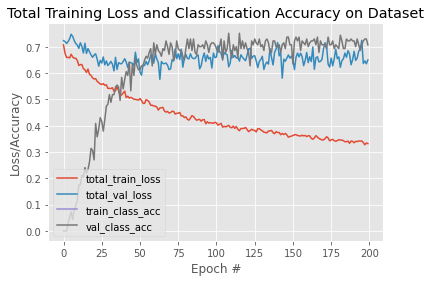

In [ ]:
# serialize the model to disk
print("[INFO] saving object detector model...")
# torch.save(model, MODEL_PATH)
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["total_train_loss"], label="total_train_loss")
plt.plot(H["total_val_loss"], label="total_val_loss")
plt.plot(H["train_class_acc"], label="train_class_acc")
plt.plot(H["val_class_acc"], label="val_class_acc")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# save the training plot
plotPath = os.path.sep.join([PLOTS_PATH, "training.png"])
plt.savefig(plotPath)

In [ ]:
model.eval()
result()

In [ ]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
model = torch.load("/content/output/detector_FasterRCNN_200epochs.pth")
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=(0.5,), std=(0.5,))
      Resize(min_size=(100,), max_size=100, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Se

In [ ]:
signs = dict(zip(le.classes_, le.transform(le.classes_)))

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.transpose((2, 0, 1))
    # convert image to PyTorch tensor, normalize it, flash it to the
    # current device, and add a batch dimension
    image = torch.from_numpy(image)
    image = transforms(image).to(config.DEVICE)
    image = image.unsqueeze(0)
    
    (boxPreds, labelPreds) = model(image)
    (startX, startY, endX, endY) = boxPreds[0]
    # determine the class label with the largest predicted
    # probability
    labelPreds = torch.nn.Softmax(dim=-1)(labelPreds)
    i = labelPreds.argmax(dim=-1).cpu()
    label = le.inverse_transform(i)[0]
    
    (h, w) = image.shape[:2]
    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    # draw the predicted bounding box and class label on the image
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(orig, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
        0.65, (0, 255, 0), 2)
    cv2.rectangle(orig, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    # show the output image 
    cv2.imshow("Output", orig)
    cv2.waitKey(0)

error: ignored